In [16]:
import torch
import torch.nn.functional as F
import torchvision.transforms as T
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA

patch_h = 32
patch_w = 32
# feat_dim = 384 # vits14
#feat_dim = 768 # vitb14
# feat_dim = 1024 # vitl14
feat_dim = 1536 # vitg14

transform = T.Compose([
   # T.GaussianBlur(9, sigma=(0.1, 2.0)),
    #T.Resize((patch_h * 14, patch_w * 14)),
    #T.CenterCrop((patch_h * 14, patch_w * 14)),
    #T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

to_tensor = T.Compose([T.ToTensor()])

# dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
#dinov2_vitb14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')
# dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
dinov2_vitb14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14').cuda()

Using cache found in /u/hwjiang/.cache/torch/hub/facebookresearch_dinov2_main


./visualization/teaser_imgs/image12.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


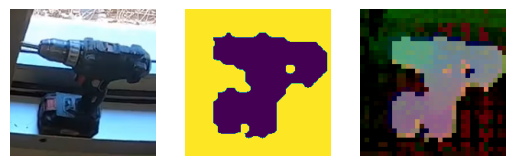

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


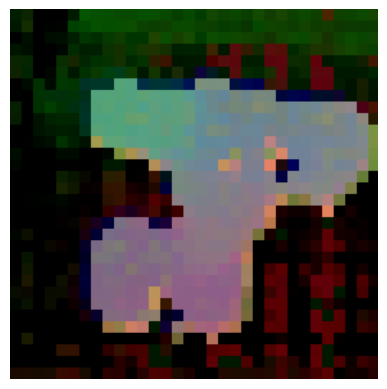

In [37]:
root = './visualization/teaser_imgs/'

img_list = []
for it in os.listdir(root):
    if 'feat' not in it:
        img_list.append(it)

for img_name in img_list[:1]:
    img_path = os.path.join(root, img_name)
    print(img_path)
    img = Image.open(img_path).convert('RGB')
    img = np.asarray(img)
    img_tensor = to_tensor(img)     # value range [0,1], [c,h,w]
    _, oheight, owidth = img_tensor.shape
    img_tensors_resized = F.interpolate(img_tensor.unsqueeze(0), size=(patch_h * 14, patch_w * 14), mode='bilinear')
    img_tensors_resized = transform(img_tensors_resized).cuda()

    with torch.no_grad():
        features_dict = dinov2_vitb14.forward_features(img_tensors_resized)
        features = features_dict['x_norm_patchtokens']
        features = features.reshape(patch_h * patch_w, feat_dim).cpu()

    pca = PCA(n_components=3)
    pca.fit(features)
    pca_features = pca.transform(features)

    # visualize PCA components for finding a proper threshold
    # plt.subplot(1, 3, 1)
    # plt.hist(pca_features[:, 0])
    # plt.subplot(1, 3, 2)
    # plt.hist(pca_features[:, 1])
    # plt.subplot(1, 3, 3)
    # plt.hist(pca_features[:, 2])
    # plt.show()
    # plt.close()

    pca_features_bg = pca_features[:, 0] < 10
    pca_features_bg = torch.tensor(pca_features_bg).reshape(patch_h, patch_w).unsqueeze(0).float()
    pca_features_bg = F.interpolate(pca_features_bg.unsqueeze(0), size=(oheight, owidth), mode='bilinear').squeeze().numpy()
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10))
    pca_features_bg = cv2.morphologyEx(pca_features_bg,cv2.MORPH_OPEN,kernel)
    pca_features_bg = pca_features_bg > 0.5
    pca_features_fg = ~pca_features_bg

    # PCA for only foreground patches
    pca_features_fg = torch.tensor(pca_features_fg).unsqueeze(0).unsqueeze(0).float()
    pca_features_fg = F.interpolate(pca_features_fg, size=(patch_h, patch_w), mode='nearest').reshape(-1) > 0.5
    pca_features_rem = pca.transform(features.reshape(-1, feat_dim)[pca_features_fg])
    for i in range(3):
        #pca_features_rem[:, i] = (pca_features_rem[:, i] - pca_features_rem[:, i].min()) / (pca_features_rem[:, i].max() - pca_features_rem[:, i].min())
        # transform using mean and std, I personally found this transformation gives a better visualization
        pca_features_rem[:, i] = (pca_features_rem[:, i] - pca_features_rem[:, i].mean()) / (pca_features_rem[:, i].std() ** 2) + 0.5

    pca_features_rgb = pca_features.copy() * 0.01
    #pca_features_rgb[~pca_features_fg] = 1.0
    pca_features_rgb[pca_features_fg] = pca_features_rem

    pca_features_rgb = pca_features_rgb.reshape(1, patch_h, patch_w, 3)
    pca_features_rgb = torch.tensor(pca_features_rgb).permute(0,3,1,2)
    pca_features_rgb = F.interpolate(pca_features_rgb, size=(oheight, owidth), mode='nearest').squeeze().permute(1,2,0)

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(pca_features_bg)
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(pca_features_rgb.numpy()[..., ::-1])
    plt.axis('off')
    #plt.savefig('features.png')
    plt.show()
    plt.close()

    plt.imshow(pca_features_rgb.numpy()[..., ::-1])
    plt.axis('off')
    plt.savefig(img_path.replace('.png', '_feat2.png'), bbox_inches='tight', pad_inches=0)
    

In [23]:
pca_features_rem.shape

(347, 3)